In [1]:
from dataset import BufferedGeoDataLoader
import xarray as xr
import numpy as np
from tqdm import tqdm
import time

In [2]:
buffer = BufferedGeoDataLoader(fold_id=0, num_wokers=8)

In [3]:
train_loader = buffer.train_dataloader()

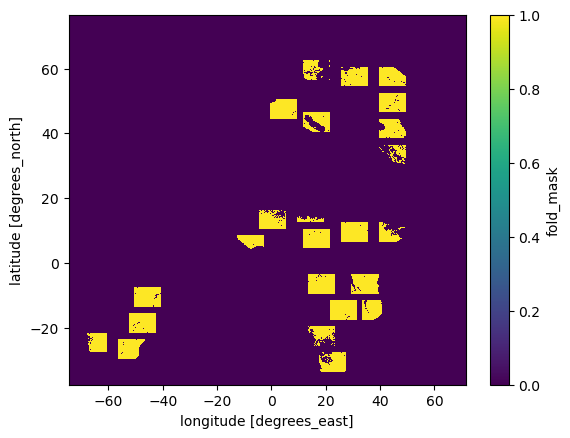

In [4]:
train_loader.dataset.mask.plot()

In [5]:
target = xr.full_like(train_loader.dataset.mask, np.nan, dtype='float32')

import traceback
try:
    for i, b in tqdm(enumerate(train_loader), maxinterval=0.1, total=len(train_loader), ncols=80):
        target.loc[{'lat': xr.DataArray(b.coords.lat), 'lon': xr.DataArray(b.coords.lon)}] = i
        time.sleep(0.5)
except:
    traceback.print_exc()

  6%|██▍                                     | 133/2213 [03:36<18:37,  1.86it/s]

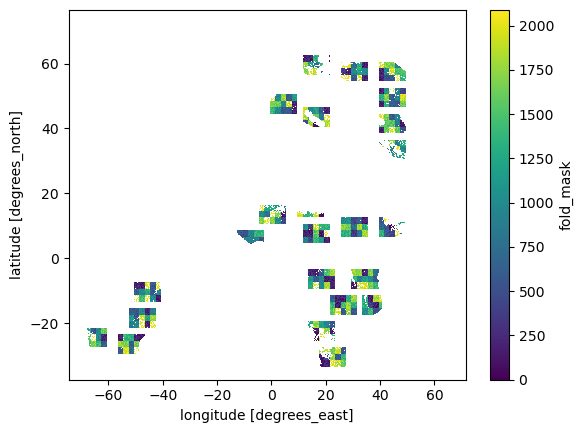

In [12]:
target.plot()

In [1]:
import xarray as xr

ds = xr.open_zarr('/Net/Groups/BGI/scratch/bkraft/drought_data/cube.zarr/')
mask = ds.fold_mask.sel(fold=[0, 2, 3, 5]).any('fold').load()

In [12]:
num_folds = 6
fold_id = 0

if (fold_id < 0) or (fold_id > num_folds - 1):
    raise ValueError(
        f'`fold_id` out of range; must be an integer in the range (0, {num_folds - 1})'
    )

folds = {fold for fold in range(num_folds)}
val_fold = fold_id
test_fold = (fold_id + 3) % 6
folds = folds - {val_fold, test_fold,}
folds = list(folds)

In [8]:
print(folds)
print(val_fold)
print(test_fold)


[0, 1, 3, 4]
5
2


In [1]:
import multiprocessing as mp
import ctypes
import numpy as np

In [2]:
import torch
from torch.utils.data import IterableDataset, DataLoader
import numpy as np
import multiprocessing as mp

class Iterator(object):
    def __init__(self, name, n=4, s=2):
        self.name = name
        self.n = n
        self.s = s
        self._start = 0

    def is_last(self):
        return (self.n - self._start) < self.s

    def __next__(self):
        if self._start == self.n:
            raise StopIteration
        else:
            end = min(self.n, self._start + self.s)
            samples = list(range(self._start, end))

            self._start = end
            return samples


class Buffer(object):
    def __init__(self):
        self.buffers: list[Iterator] = []

    def add_iterator(self, iterator):
        self.buffers.append(iterator)

    def __len__(self):
        return len(self.buffers)

    def __next__(self):
        worker_info = torch.utils.data.get_worker_info()
        if worker_info is None:
            worker_id = None
        else:
            worker_id = worker_info.id

        if len(self) == 0:
            raise StopIteration
        else:
            combined_res = []
            empty = []
            idx = []
            for i, buffer in enumerate(self.buffers):
                res = next(buffer)
                if res is None:
                    empty.append(i)
                else:
                    combined_res.extend(res)
                idx.append(buffer.name)

            for i in reversed(empty):
                self.buffers.pop(i)

            return f'idx {idx} | result {combined_res} | worker {worker_id}'

class MyDataset(IterableDataset):
    def __init__(self, shuffle = False, buffer_size = 2):
        self.samples = np.arange(10)
        self.buffer_size = buffer_size

        if shuffle:
            np.random.shuffle(self.samples)

        self.current_index = mp.Value('i', 0)

    def __len__(self):
        return len(self.samples)
    
    def __iter__(self):
        buffer = Buffer()
        while True:
            idx = self.current_index.value
            self.current_index.value += 1

            # If valid new index:
            if idx < len(self):
                print('added buffer')
                buffer.add_iterator(Iterator(idx, 4, 2))

                # If buffer not filled, get next index
                if len(buffer) < self.buffer_size:
                    continue

            if (idx >= len(self)) and (len(buffer) == 0):
                print('exit')
                return None

            try:
                print('yield')
                yield from buffer
            except StopIteration as e:
                print('StopIteration')
                continue


In [3]:
mydata = MyDataset()
dataloader = DataLoader(mydata, num_workers=2, prefetch_factor=1)

In [4]:
for b in dataloader:
    print(b)

added bufferadded buffer

added bufferadded buffer

yieldyield



TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/Net/Groups/BGI/people/bkraft/anaconda3/envs/dml/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 287, in _worker_loop
    data = fetcher.fetch(index)
  File "/Net/Groups/BGI/people/bkraft/anaconda3/envs/dml/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 32, in fetch
    data.append(next(self.dataset_iter))
  File "/raid/scratch/tmp/ipykernel_58231/297785992.py", line 97, in __iter__
    yield from buffer
TypeError: 'Buffer' object is not iterable


In [112]:
ds = MyDataset()

In [120]:
ds.shared_array.value += 1

In [121]:
ds.shared_array

<Synchronized wrapper for c_int(4)>

In [52]:
class Iterator(object):
    def __init__(self, name, n=4, s=2):
        self.name = name
        self.n = n
        self.s = s
        self._start = 0

    def __iter__(self):
        while True:
            if self._start == len(self.n):
                self._start = 0
                return None
            else:
                end = min(self.n, self._start + self.s)
                samples = list(range(self._start, end))

                self._start = end
                yield samples

class MetaIterator(object):
    def __init__(self, id):
        self.id = id

    def __iter__(self):
        if self.i < self.n:
            result = self.i 
            self.i += 1
            yield result
        else:
            self.i = 0
            return

class SuperIterator(object):
    def __init__(self):
        pass

    def __iter__(self):
        pass

In [77]:
iterator0 = Iterator()
iterator1 = Iterator()
iterator2 = Iterator()
iterator3 = Iterator()

In [78]:
iterators = [iter(iterator0), iter(iterator1), iter(iterator2), iter(iterator3)]

In [60]:
while True:
    for iterator in [Iterator(), Iterator()]:
        

1
0
2
1
3
2


StopIteration: 

In [75]:
np.zeros(1).mean(axis=0)

0.0

In [46]:
batch_size = 20
buffer_size = 3

In [47]:
avg_sample_size = batch_size / buffer_size
avg_sample_size

6.666666666666667

In [48]:
batch_size / np.arange(0, buffer_size).sum()

6.666666666666667

In [44]:
(3 * batch_size) / (2 * buffer_size)

4.285714285714286

In [42]:
samples_per_batch = batch_size / buffer_size

np.arange(batch_size / buffer_size - buffer_size / 2, batch_size / buffer_size + buffer_size / 2)

array([-0.64285714,  0.35714286,  1.35714286,  2.35714286,  3.35714286,
        4.35714286,  5.35714286])

In [38]:
int(np.ceil(batch_size / buffer_size))

7

In [35]:
buffer_sample_sizes = [batch_size // buffer_size] * (buffer_size - 1)
buffer_sample_sizes += [batch_size - np.sum(buffer_sample_sizes)]
buffer_sample_sizes

[6, 6, 8]

In [26]:
import torch
import math
from torch.utils.data import IterableDataset, DataLoader
import xarray as xr
import numpy as np
from itertools import islice

from typing import Iterable


class Data(object):
    def __init__(self, ds: xr.Dataset, mask: xr.DataArray, sample_size: int, shuffle: bool) -> None:
        self.ds = ds
        self.mask = mask
        self.sample_size = sample_size

        self.coords = np.argwhere(mask.values)

        if shuffle:
            np.random.shuffle(self.coords)

        self._start = 0

    def __len__(self) -> int:
        return len(self.coords)

    def __getitem__(self, idx: int) -> xr.Dataset:

        batch = next(self.batch_iterator)

        return batch

    def __iter__(self) -> Iterable:
        while True:
            if self._start == len(self.coords):
                self._start = 0
                return None
            else:
                end = min(len(self.coords), self._start + self.sample_size)
                coords = self.coords[self._start:end]
                samples = self.ds[xr.DataArray(coords[:, 0], dims=['sample']), xr.DataArray(coords[:, 1], dims=['sample'])]

                self._start = end
                yield samples


class DataBuffer(object):
    def __init__(self, ds: xr.Dataset, chunk_mask: xr.DataArray, latlon_slices: slice, batch_size: int, buffer_size: int, shuffle: bool = False):

        self.ds = ds
        self.chunk_mask = chunk_mask
        self.latlon_slices = latlon_slices
        self.batch_size = batch_size
        self.buffer_size = buffer_size
        self.shuffle = shuffle

        self.buffer = {}

        self.buffer_sample_sizes = []

    def update_buffer(self):
        pass

    def add_chunk(self, chunk_id, ds, mask):
        self.batch_size / self.buffer_size
        self.buffer.update({chunk_id: Data(ds, mask, sample_size=self.sample_size, shuffle=self.shuffle)})

    def get_batch(self):
        pass


class BufferDataset(IterableDataset):
    def __init__(
            self,
            mask: xr.DataArray,
            batch_size: int,
            chunk_size: int,
            buffer_size: int):

        super().__init__()

        self.mask = mask
        self.batch_size = batch_size
        self.chunk_size = chunk_size
        self.buffer_size = buffer_size
        self.chunk_count = mask.coarsen(lat=self.chunk_size, lon=self.chunk_size).sum().compute()
        self.chunk_mask = self.chunk_count > 0
        self.chunk_coords = np.argwhere(self.chunk_mask.values)

        interval_dtype = np.dtype([('start', int), ('stop', int)])
        self.chunk_mask = self.chunk_mask.assign_coords(
            lat_bounds=('lat', np.array([(s, e) for s, e in self._get_slice_bounds('lat')], dtype=interval_dtype)),
            lon_bounds=('lon', np.array([(s, e) for s, e in self._get_slice_bounds('lon')], dtype=interval_dtype))
        )

    def shuffle(self):
        np.random.shuffle(self.chunk_coords)

    def __iter__(self):
        worker_info = torch.utils.data.get_worker_info()
        worker_id = worker_info.id
        num_workers = worker_info.num_workers
        per_worker = int(math.ceil((self.num_chunks) / float(num_workers)))

        iter_start = worker_id * per_worker
        iter_end = min(iter_start + per_worker, self.num_chunks)

        #worker_chunk_coords = [self.worker_chunk_coords[i] for i in range(iter_start, iter_end)]

        return iter(range(iter_start, iter_end))

        if worker_id is None:
            self.worker_chunk_coords = {worker_id: self.chunk_coords}

        return itr

    def _get_slice_bounds(self, dim: str) -> np.ndarray:
        return np.lib.stride_tricks.sliding_window_view(np.arange(0, len(mask[dim]) + 1, self.chunk_size), 2)

    def _block_coord_to_slices(self, idx: int) -> tuple[slice]:
        lat_block, lon_block = self.chunk_coords[idx]
        lat_slice = slice(*self.chunk_mask.lat_bounds[lat_block])
        lon_slice = slice(*self.chunk_mask.lon_bounds[lon_block])

        return lat_slice, lon_slice

    @property
    def num_chunks(self) -> int:
        return len(self.chunk_coords)

In [27]:
d = BufferDataset(mask, 10, 20, 4)

In [28]:
data = Data(d.mask.isel(lat=slice(160, 180), lon=slice(1000, 1020)), d.mask.isel(lat=slice(160, 180), lon=slice(1000, 1020)), 7, shuffle=False)

In [30]:
list(data)

[<xarray.DataArray 'fold_mask' (sample: 7)>
 array([ True,  True,  True,  True,  True,  True,  True])
 Coordinates:
     lat      (sample) float32 60.5 60.5 60.5 60.5 60.5 60.5 60.5
     lon      (sample) float32 25.5 25.6 25.7 25.8 25.9 26.0 26.1
 Dimensions without coordinates: sample,
 <xarray.DataArray 'fold_mask' (sample: 7)>
 array([ True,  True,  True,  True,  True,  True,  True])
 Coordinates:
     lat      (sample) float32 60.5 60.5 60.5 60.5 60.5 60.5 60.4
     lon      (sample) float32 26.3 26.4 26.7 26.8 26.9 27.0 25.5
 Dimensions without coordinates: sample,
 <xarray.DataArray 'fold_mask' (sample: 7)>
 array([ True,  True,  True,  True,  True,  True,  True])
 Coordinates:
     lat      (sample) float32 60.4 60.4 60.4 60.4 60.4 60.4 60.4
     lon      (sample) float32 25.6 25.7 25.8 25.9 26.1 26.2 26.3
 Dimensions without coordinates: sample,
 <xarray.DataArray 'fold_mask' (sample: 7)>
 array([ True,  True,  True,  True,  True,  True,  True])
 Coordinates:
     lat      (sa

In [211]:
for i, batch in enumerate(data.get_next_items()):
    print(i, batch)

In [224]:
d = BufferDataset(mask, 10, 20, 4)

In [128]:
ds.chunk_mask.lat_bounds[8]

<xarray.DataArray 'lat_bounds' ()>
array((160, 180), dtype=[('start', '<i8'), ('stop', '<i8')])
Coordinates:
    lat         float32 59.55
    lat_bounds  [('start', '<i8'), ('stop', '<i8')] (160, 180)

In [127]:
ds.chunk_mask.lon_bounds[50]

<xarray.DataArray 'lon_bounds' ()>
array((1000, 1020), dtype=[('start', '<i8'), ('stop', '<i8')])
Coordinates:
    lon         float32 26.45
    lon_bounds  [('start', '<i8'), ('stop', '<i8')] (1000, 1020)

In [79]:
ds.shuffle()

In [80]:
for batch in DataLoader(ds, batch_size=2, num_workers=2):
    print(batch)

tensor([0, 1])
tensor([173, 174])
tensor([2, 3])
tensor([175, 176])
tensor([4, 5])
tensor([177, 178])
tensor([6, 7])
tensor([179, 180])
tensor([8, 9])
tensor([181, 182])
tensor([10, 11])
tensor([183, 184])
tensor([12, 13])
tensor([185, 186])
tensor([14, 15])
tensor([187, 188])
tensor([16, 17])
tensor([189, 190])
tensor([18, 19])
tensor([191, 192])
tensor([20, 21])
tensor([193, 194])
tensor([22, 23])
tensor([195, 196])
tensor([24, 25])
tensor([197, 198])
tensor([26, 27])
tensor([199, 200])
tensor([28, 29])
tensor([201, 202])
tensor([30, 31])
tensor([203, 204])
tensor([32, 33])
tensor([205, 206])
tensor([34, 35])
tensor([207, 208])
tensor([36, 37])
tensor([209, 210])
tensor([38, 39])
tensor([211, 212])
tensor([40, 41])
tensor([213, 214])
tensor([42, 43])
tensor([215, 216])
tensor([44, 45])
tensor([217, 218])
tensor([46, 47])
tensor([219, 220])
tensor([48, 49])
tensor([221, 222])
tensor([50, 51])
tensor([223, 224])
tensor([52, 53])
tensor([225, 226])
tensor([54, 55])
tensor([227, 228])
te

In [81]:
ds.chunk_mask

<xarray.DataArray 'fold_mask' (lat: 57, lon: 73)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * lat      (lat) float32 75.55 73.55 71.55 69.55 ... -32.45 -34.45 -36.45
  * lon      (lon) float32 -73.55 -71.55 -69.55 -67.55 ... 66.45 68.45 70.45

array([(   0,   20), (  20,   40), (  40,   60), (  60,   80),
       (  80,  100), ( 100,  120), ( 120,  140), ( 140,  160),
       ( 160,  180), ( 180,  200), ( 200,  220), ( 220,  240),
       ( 240,  260), ( 260,  280), ( 280,  300), ( 300,  320),
       ( 320,  340), ( 340,  360), ( 360,  380), ( 380,  400),
       ( 400,  420), ( 420,  440), ( 440,  460), ( 460,  480),
       ( 480,  500), ( 500,  520), ( 520,  540), ( 540,  560),
       ( 560,  580), ( 580,  600), ( 600,  620), ( 620,  640),
       ( 640,  660), ( 660,  680), ( 680,  700), ( 700,  720),
       ( 720,  740), ( 740,  760), ( 760,  780), ( 780,  800),
       ( 800,  820), ( 820,  840), ( 840,  860), ( 860,  880),
       ( 880,  900), ( 900,  920), ( 920,  940), ( 940,  960),
       ( 960,  980), ( 980, 1000), (1000, 1020), (1020, 1040),
       (1040, 1060), (1060, 1080), (1080, 1100), (1100, 1120),
       (1120, 1140), (1140, 1160), (1160, 1180), (1180, 1200),
       (1200, 1220), (1220, 1240), (1240, 1260), (1260,

In [105]:
interval_dtype = np.dtype([('start', int), ('stop', int)])

ds.chunk_mask.assign_coords(
    lat_bounds=('lat', np.array([(s, e) for s, e in ds.lat_bounds], dtype=interval_dtype)),
    lon_bounds=('lon', np.array([(s, e) for s, e in ds.lon_bounds], dtype=interval_dtype))
)

<xarray.DataArray 'fold_mask' (lat: 57, lon: 73)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * lat         (lat) float32 75.55 73.55 71.55 69.55 ... -32.45 -34.45 -36.45
  * lon         (lon) float32 -73.55 -71.55 -69.55 -67.55 ... 66.45 68.45 70.45
    lat_bounds  (lat) [('start', '<i8'), ('stop', '<i8')] (0, 20) ... (1120, ...
    lon_bounds  (lon) [('start', '<i8'), ('stop', '<i8')] (0, 20) ... (1440, ...

In [7]:
import torch
from torch.utils.data import IterableDataset, DataLoader, default_collate, ChainDataset
import xarray as xr
import numpy as np
from collections import namedtuple
import multiprocessing as mp
import dask
import time
from tqdm import tqdm

dask.config.set(scheduler='synchronous')

/Net/Groups/BGI/people/bkraft/anaconda3/envs/dml/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [36]:
class NotEnoughSamplesError(Exception):
    """Exception raised if not enough samples are left to fill a batch.
    """

    def __init__(self, message='Not enough samples left.'):
        super().__init__(message)


class NoMoreChunksError(Exception):
    """Exception raised if no chunks are left.
    """

    def __init__(self, message='No chunks left.'):
        super().__init__(message)


BatchPattern = namedtuple('BatchPattern', 'f_hourly f_static t_hourly, t_daily coords')
Coords = namedtuple('Coords', 'lat, lon')

def custom_collate(batch: list[BatchPattern]) -> BatchPattern:
    """Custom collate function to stack batched return values.

    The collate function merges the first two dimensions of batch elements and stacks list elements,
    assuming keys
        * `f_hourly`     (=features hourly) [hours, seq_len, num_samples, num_hourly_features]
        * `f_static`     (=features static) [num_samples, num_static_features]
        * `t_hourly`     (=targets hourly)  [hours, seq_len, num_samples, num_hourly_targets]
        * `t_daily`      (=targets daily)   [seq_len, num_samples, num_daily_targets]
        * `coords`       (=lat, lon)        [num_samples, 2]

    The list elements stacked per field along the `samples` dimension. The resulting batch is again
    of type `BatchPattern`.

    Args:
        batch: a list of BatchPattern.

    Returns:
        A BatchPattern corresponding to stacked individual elements in the list of batches.

    """
    elem_type = type(batch[0])

    return elem_type(*(default_collate(samples) for samples in zip(*batch)))


class DataChunk(object):
    def __init__(
            self,
            data: xr.Dataset,
            mask: xr.DataArray,
            shuffle: bool = False,
            features_hourly: list[str] = [],
            features_static: list[str] = [],
            targets_hourly: list[str] = [],
            targets_daily: list[str] = [],
            feature_scaling: dict[str, dict[str, float]] = None,
            dtype: str = 'float32') -> None:

        self.data = data.load()
        self.mask = mask

        self.features_hourly = features_hourly
        self.features_static = features_static
        self.targets_hourly = targets_hourly
        self.targets_daily = targets_daily

        self.feature_scaling = feature_scaling
        self.dtype = dtype

        self.coords = np.argwhere(mask.values)
        if shuffle:
            np.random.shuffle(self.coords)

        self._current_sample = 0

    def next(self) -> BatchPattern:
        worker_info = torch.utils.data.get_worker_info()

        if worker_info is None:
            worker_id = -1
        else:
            worker_id = worker_info.id

        lat, lon = self.coords[self._current_sample]
        self._current_sample += 1

        data_sel = self.data.isel(lat=lat, lon=lon)

        return BatchPattern(
            f_hourly=self.xr2numpy(data_sel[self.features_hourly], scale=True),
            f_static=self.xr2numpy(data_sel[self.features_static], scale=True),
            t_hourly=self.xr2numpy(data_sel[self.targets_hourly], scale=False),
            t_daily=self.xr2numpy(data_sel[self.targets_daily], scale=False),
            coords=Coords(lat=data_sel.lat.item(), lon=data_sel.lon.item())
        )

    def get_n_next(self, n: int):
        result = []
        for _ in range(n):
            result.append(self.next())

        return result

    def xr2numpy(self, x: xr.Dataset, scale: bool) -> np.ndarray:
        if scale:
            if self.feature_scaling is None:
                raise ValueError(
                    'no `feature_scaling` has been passed but scling was requested.'
                )
            for var in x.data_vars:
                if var not in self.feature_scaling:
                    raise KeyError(
                        f'scling for variable `{var}` requested, but not present in `feature_scaling`.'
                    )
                scaling = self.feature_scaling[var]
                data_min = scaling['min']
                data_max = scaling['max']
                x[var] = (x[var] - data_min) * 2 / (data_max - data_min) - 1

        return x.to_array('var').transpose('hour', 'time', 'var', missing_dims='ignore').values.astype(self.dtype)

    def __repr__(self) -> str:
        return f'DataChunk()'

    @property
    def num_left(self) -> int:
        return len(self.coords) - self._current_sample


class Buffer(object):
    def __init__(self) -> None:
        self.chunks = []

    def add_chunk(self, chunk) -> None:
        self.chunks.append(chunk)

    def clean_empty_chunks(self) -> None:
        empty = []
        for i, chunk in enumerate(self.chunks):
            if chunk.num_left == 0:
                empty.append(i)

        for i in reversed(empty):
            self.chunks.pop(i)

    def get_n_next(self, n: int, return_remaining: bool = False):
        sizes = self._distribute_batch(n=n, return_all=return_remaining)
        res = [c.get_n_next(s) for c, s in zip(self.chunks, sizes)]
        res = [item for sublist in res for item in sublist]
        self.clean_empty_chunks()
        return res

    @property
    def num_chunks(self) -> int:
        return len(self.chunks)

    @property
    def num_left(self) -> int:
        return sum(chunk.num_left for chunk in self.chunks)

    @property
    def num_left_per_chunk(self) -> int:
        return [chunk.num_left for chunk in self.chunks]

    def _distribute_batch(self, n: int, return_all: bool = False) -> list[int]:
        num_left = self.num_left_per_chunk

        if return_all:
            return num_left

        if sum(num_left) < n:
            raise NotEnoughSamplesError()
            
        suggested_sizes = [min(num_left[i], int(n // len(num_left))) for i in range(len(num_left))]
        num_missing = n - sum(suggested_sizes)

        i = 0
        while num_missing > 0:
            i_ = i % len(suggested_sizes)
            if num_left[i_] - suggested_sizes[i_] > 0:
                suggested_sizes[i_] += 1
                num_missing -= 1
            i += 1

        return suggested_sizes


class BufferedDataset(IterableDataset):
    def __init__(
            self,
            data: xr.Dataset,
            mask: xr.DataArray,
            batch_size: int,
            num_buffer: int,
            features_hourly: list[str] = [],
            features_static: list[str] = [],
            targets_hourly: list[str] = [],
            targets_daily: list[str] = [],
            drop_last: bool = False,
            chunk_size: int = 20) -> None:
        """Initialize BufferedDataset.

        Args:
            ds: the dataset containing spatio-temporal observations. Must at least have
                the dimensions `lat` and `lon`.
            mask: a spatio-temporal mask indicating valid pixels (`True`). Must at least have
                the dimensions `lat` and `lon` equal to `ds`.
            chunk_size: the latitude/longitude chunk sizes. Must divide the
                `ds.lat`/`ds.lon` chunk size without remainder.
            sample_chunk_size: the smallest sample unit. E.g., with `sample_chunk_size = 10`, a block
                of size 10 x 10 is read at once and returned.
            features_hourly: a list of hourly dynamic features, must be data variables of `ds`.
            features_static: a list of static features, must be data variables of `ds`.
            targets_hourly: a list of hourly dynamic targets, must be data variables of `ds`.
            targets_daily: a list of daily dynamic targets, must be data variables of `ds`.
            dummy_data: If set to `True`, dummy data (random normal) will be returned.
            dtype: the numeric data type to be returned, default is `float32`.

        """

        super().__init__()

        self.data = data
        self.mask = mask.load()
        self.features_hourly = [features_hourly] if isinstance(features_hourly, str) else features_hourly
        self.features_static = [features_static] if isinstance(features_static, str) else features_static
        self.targets_hourly = [targets_hourly] if isinstance(targets_hourly, str) else targets_hourly
        self.targets_daily = [targets_daily] if isinstance(targets_daily, str) else targets_daily
        self._check_ds(ds=self.data, mask=self.mask)
        self.feature_scaling = self._get_scaling(self.data, self.features_hourly, self.features_static)

        self.num_samples = self.mask.sum().compute().item()
        self.chunk_mask = mask.coarsen(lat=chunk_size, lon=chunk_size).sum().compute()
        self.batch_size = batch_size
        self.num_buffer = num_buffer
        self.drop_last = drop_last
        self.chunk_size = chunk_size

        self.chunk_coords = np.argwhere(self.chunk_mask.values)

        self.chunk_bounds_lat = self.coords2bounds('lat')
        self.chunk_bounds_lon = self.coords2bounds('lon')

        self._was_shuffled = mp.Value('i', 0)
        self._current_chunk = mp.Value('i', 0)
        self._shared_indices = mp.Array('i', self.num_chunks)
        self._shared_indices[:] = [i for i in range(self.num_chunks)]

    def _get_scaling(
            self,
            data: xr.Dataset,
            features_hourly: list[str],
            features_static: list[str]) -> dict[str, dict[str, float]]:
        # TODO: recompute cube and get scaling from attributes.

        min_max = {}

        for var in features_hourly:
            enc = data[var].encoding
            data_min = enc['add_offset'] - 30000 * enc['scale_factor']
            data_max = enc['scale_factor'] * 60000 + data_min
            min_max.update({var: {'min': data_min, 'max': data_max}})

        for var in features_static:
            data_min = data[var].attrs['data_min']
            data_max = data[var].attrs['data_max']
            min_max.update({var: {'min': data_min, 'max': data_max}})

        return min_max

    def coords2bounds(self, dim: str):
        return np.lib.stride_tricks.sliding_window_view(range(0, len(self.mask[dim])+1, self.chunk_size), 2)

    def next_chunk(self) -> DataChunk:
        worker_info = torch.utils.data.get_worker_info()

        if worker_info is None:
            worker_id = -1
        else:
            worker_id = worker_info.id

        with self._current_chunk.get_lock():
            current_chunk = self._current_chunk.value
            if current_chunk >= self.num_chunks:
                raise NoMoreChunksError()

            current_chunk_nr = self._shared_indices[current_chunk]
            chunk_lat, chunk_lon = self.chunk_coords[current_chunk_nr]
            self._current_chunk.value += 1

        lat_bounds = slice(*self.chunk_bounds_lat[chunk_lat])
        lon_bounds = slice(*self.chunk_bounds_lon[chunk_lon])
        data_chunk = self.data.isel(lat=lat_bounds, lon=lon_bounds)
        mask_chunk = self.mask.isel(lat=lat_bounds, lon=lon_bounds)
        return DataChunk(
            data=data_chunk,
            mask=mask_chunk,
            shuffle=True,
            features_hourly=self.features_hourly,
            features_static=self.features_static,
            targets_daily=self.targets_daily,
            targets_hourly=self.targets_hourly,
            feature_scaling=self.feature_scaling,
        )

    @property
    def num_chunks(self) -> int:
        return len(self.chunk_coords)

    @property
    def num_features_hourly(self) -> int:
        return len(self.features_hourly)

    @property
    def num_features_static(self) -> int:
        return len(self.features_static)

    @property
    def num_targets_hourly(self) -> int:
        return len(self.targets_hourly)

    @property
    def num_targets_daily(self) -> int:
        return len(self.targets_daily)

    def _check_ds(
            self,
            ds: xr.Dataset,
            mask: xr.DataArray) -> None:
        """Checks dataset 'ds' properties.

        - `ds` must have chunks
        - `ds` and `mask` must have `lat` and `lon` dimensions
        - chunks must be defined for `lat` and `lon`

        Each negative check throws and error.
        """
        ch = ds.chunks
        if not len(ch):
            raise ValueError(
                'no chunks defined for the dataset `ds`.'
            )

        missing_dim = ''
        for d, d_name in zip([ds, mask], ['ds', 'mask']):
            for dim in ['lat', 'lon']:
                if dim not in d.dims:
                    missing_dim += f' `{d_name}.{dim}`'
        if missing_dim != '':
            raise ValueError(
                'the inputs `ds` and `mask` both most have dimensions `lat` and `lon`, but the '
                f'following dimensions are not present: {missing_dim}'
            )

    def __len__(self):
        worker_info = torch.utils.data.get_worker_info()

        if worker_info is None:
            if self.drop_last:
                length = int(self.num_samples // self.batch_size)
            else:
                length = int(np.ceil(self.num_samples // self.batch_size))
        else:
            if self.drop_last:
                length = int(self.num_samples / worker_info.num_workers // self.batch_size)
            else:
                length = int(self.num_samples / worker_info.num_workers // self.batch_size) + worker_info.num_workers

        return length

    def __iter__(self) -> BatchPattern:
        worker_info = torch.utils.data.get_worker_info()

        if worker_info is None:
            worker_id = -1
        else:
            worker_id = worker_info.id

        with self._was_shuffled.get_lock():
            if self._was_shuffled.value == 0:
                self._shared_indices[:] = np.random.permutation(self._shared_indices)
                self._current_chunk.value = 0
                self._was_shuffled.value = 1

        buffer = Buffer()
        is_last_chunk = False
        is_last_batch = False
        while True:
            # No more batches
            if is_last_batch:
                self._was_shuffled.value = 0
                return

            # Add chunk and start over or set last chunk.
            if not is_last_chunk:
                try:
                    if buffer.num_chunks < self.num_buffer:
                        next_chunk = self.next_chunk()
                        buffer.add_chunk(next_chunk)

                        continue

                except NoMoreChunksError as e:
                    is_last_chunk = True

            # Get next batch.
            try:
                # If enough samples in buffer, return them.
                yield default_collate(buffer.get_n_next(self.batch_size))
            except NotEnoughSamplesError as e:
                # If not enough samples in buffer...
                # ...try to add chunk if more available, and start over.
                try:
                    next_chunk = self.next_chunk()
                    buffer.add_chunk(next_chunk)
                    continue
                except NoMoreChunksError as e:
                    # ...or get last batch if not drop_last.
                    is_last_batch = True
                    if (not self.drop_last) or (buffer.num_left < 1):
                        yield default_collate(buffer.get_n_next(self.batch_size, return_remaining=True))

def worker_init_fn(worker_id: int):
    "Desynchonize workers."
    if worker_id > 0:
        time.sleep(np.random.uniform(1, 10))

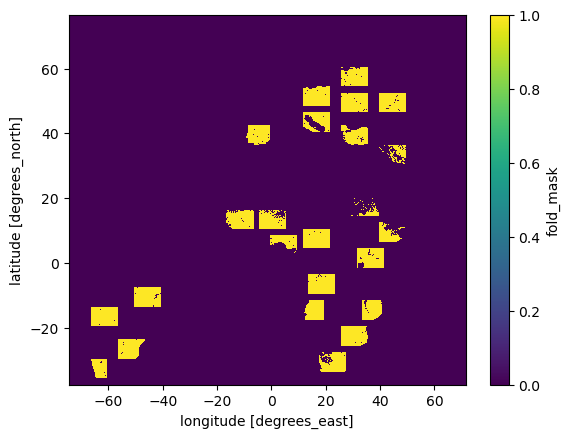

In [37]:
#ds_subset = ds.isel(lat=slice(600, 800), lon=slice(1000, 1200))
#mask_subset = ds_subset.fold_mask.sel(fold=[0, 2, 3, 5]).any('fold').load()
target = xr.full_like(mask, np.nan, dtype='float32')
mask.plot()

In [64]:
bds = BufferedDataset(
    data=ds,
    mask=mask,
    batch_size=50,
    num_buffer=5,
    features_hourly=['rh_cf', 'ssrd', 't2m', 'tp'],
    features_static=['canopyheight', 'rootdepth', 'percent_tree_cover', 'sandfrac', 'topidx', 'wtd'],
    targets_daily=['fvc'],
    targets_hourly=['lst'],
    drop_last=False
)
dataloader = DataLoader(
    bds,
    num_workers=10,
    batch_size=None,
    worker_init_fn=worker_init_fn
)


In [65]:
target = xr.full_like(mask, np.nan, dtype='float32')

import traceback
try:
    for i, b in tqdm(enumerate(dataloader), maxinterval=0.1, total=len(bds), ncols=80):
        target.loc[{'lat': xr.DataArray(b.coords.lat), 'lon': xr.DataArray(b.coords.lon)}] = i
        #time.sleep(0.5)
except:
    traceback.print_exc()



2221it [23:40,  1.56it/s]                                                       


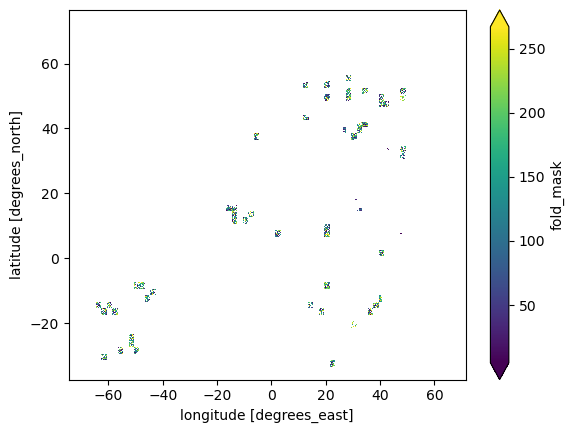

In [62]:
target.plot(robust=False, cmap='jet')